# Attentative Neural Processes for Self Guided Colorization

This note book will test attentative neural processes (ANP) on self guided colorization. Self guided colorization is the act of predicing the chroma channels of an entire image give the knowledge of some known colors from the image.

## Imports
Import needed for both tasks.

In [0]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import collections

#### Multihead attention
The version below is supposed to be more optimized but provides a very noisy
result and isn't much faster so it is commented out.

In [0]:
# class MultiheadAttention(nn.Module):
#     """
#     Multihead attention mechanism (dot attention)
#     """
#     def __init__(self, num_hidden_k):
#         """
#         :param num_hidden_k: dimension of hidden 
#         """
#         super(MultiheadAttention, self).__init__()

#         self.num_hidden_k = num_hidden_k
#         self.attn_dropout = nn.Dropout(p=0.1)

#     def forward(self, key, value, query):
#         # Get attention score
#         attn = torch.bmm(query, key.transpose(1, 2))
#         attn = attn / np.sqrt(self.num_hidden_k)
        
#         attn = torch.softmax(attn, dim=-1)

#         # Dropout
#         # attn = self.attn_dropout(attn)
        
#         # Get Context Vector
#         result = torch.bmm(attn, value)

#         return result, attn


# class Attention(nn.Module):
#     """
#     Attention Network
#     """
#     def __init__(self, input_size, key_sizes, query_sizes, repr_size, num_hidden, h=4):
#         """
#         :param num_hidden: dimension of hidden
#         :param h: num of heads 
#         """
#         super(Attention, self).__init__()
#         # print(key_sizes, query_sizes)

#         self.num_hidden = num_hidden
#         self.num_hidden_per_attn = num_hidden // h
#         self.h = h

#         query = [nn.Linear(input_size, query_sizes[0]), nn.ReLU(inplace=True)]
#         for i in range(1, len(query_sizes)):
#             query += [nn.Linear(query_sizes[i - 1], query_sizes[i])]
#             if i != len(query_sizes) - 1:
#                 query += [nn.ReLU(inplace=True)]

#         self.query = nn.Sequential(*query)

#         key = [nn.Linear(input_size, key_sizes[0]), nn.ReLU(inplace=True)]
#         for i in range(1, len(key_sizes)):
#             key += [nn.Linear(key_sizes[i - 1], key_sizes[i])]
#             if i != len(key_sizes) - 1:
#                 key += [nn.ReLU(inplace=True)]

#         self.key = nn.Sequential(*key)
#         #self.key = nn.Linear(d_k, num_hidden, bias=False)
#         self.value = nn.Linear(repr_size, num_hidden, bias=False)
#         #self.query = nn.Linear(d_q, num_hidden, bias=False)

#         self.multihead = MultiheadAttention(self.num_hidden_per_attn)

#         self.residual_dropout = nn.Dropout(p=0.1)

#         self.final_linear = nn.Linear(num_hidden, num_hidden)

#         self.layer_norm = nn.LayerNorm(num_hidden)

#     def forward(self, key, value, query):

#         batch_size = key.size(0)
#         seq_k = key.size(1)
#         seq_q = query.size(1)
#         # residual = query
        
#         # Make multihead
#         # print(key.shape)
#         # print(value.shape)
#         # print(query.shape)
#         key = self.key(key).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
#         value = self.value(value).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
#         query = self.query(query).view(batch_size, seq_q, self.h, self.num_hidden_per_attn)
#         residual = query.contiguous().view(batch_size, seq_q, -1)

#         key = key.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
#         value = value.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
#         query = query.permute(2, 0, 1, 3).contiguous().view(-1, seq_q, self.num_hidden_per_attn)

#         # Get context vector
#         result, attns = self.multihead(key, value, query)

#         # Concatenate all multihead context vector
#         result = result.view(self.h, batch_size, seq_q, self.num_hidden_per_attn)
#         result = result.permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)
        
#         # Concatenate context vector with input (most important)
#         # result = torch.cat([residual, result], dim=-1)
        
#         # Final linear
#         result = self.final_linear(result)

#         # Residual dropout & connection
#         # result = self.residual_dropout(result)
#         # result = result + residual

#         # Layer normalization
#         # result = self.layer_norm(result)

#         return result, attns

#### Multihead attention
Multihead attention that uses dot product attention for each head.
Code can still be optimized but need to figure out what is slowing it down.

Code below is based off of the tensorflow code from DeepMind which can be accessed [here](https://github.com/deepmind/neural-processes/blob/master/attentive_neural_process.ipynb).

In [0]:
def dot_product_attention(q, k, v):
    """
    Computes dot product attention.

    @param q: queries. tensor of  shape [B,m,d_k].
    @param k: keys. tensor of shape [B,n,d_k].
    @param v: values. tensor of shape [B,n,d_v].

    @return tensor of shape [B,m,d_v].
    """
    d_k = q.size(-1)
    scale = np.sqrt(d_k)
    # need to permute because channels needs to be the last channel for this operation
    k = k.permute(0, 2, 1)
    q = q.permute(0, 2, 1)
    v = v.permute(0, 2, 1)
    unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
    weights = F.softmax(unnorm_weights, dim=-1)  # [B,m,n]
    rep = torch.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
    # permute shape back so that it can be 
    rep = rep.permute(0, 2, 1)
    return rep


class MultiheadAttention(nn.Module):
    def __init__(self, num_heads, d_k, d_q, d_v):
        """
        Constructor for Multihead attention module.

        @param num_heads: number of heads to use.
        @param d_k: size of key.
        @param d_q: size of query.
        @param d_v: size of value.
        """
        super(MultiheadAttention, self).__init__()
        head_size = d_v // num_heads
        self.num_heads = num_heads

        heads = nn.ModuleDict()
        for i in range(num_heads):
            heads['head' + str(i) + '_key'] = nn.Conv1d(d_k, head_size, 1, bias=False)
            heads['head' + str(i) + '_query'] = nn.Conv1d(d_q, head_size, 1, bias=False)
            heads['head' + str(i) + '_value'] = nn.Conv1d(d_v, head_size, 1, bias=False)
            heads['head' + str(i) + '_fc'] = nn.Conv1d(head_size, d_v, 1, bias=False)

        self.heads = heads


    def forward(self, q, k, v):
        """
        Computes multihead attention.

        @param q: queries. tensor of  shape [B,m,d_k].
        @param k: keys. tensor of shape [B,n,d_k].
        @param v: values. tensor of shape [B,n,d_v].

        @return tensor of shape [B,m,d_v].
        """
        rep = 0.
        for i in range(self.num_heads):
            key = self.heads['head' + str(i) + '_key'](k)
            query = self.heads['head' + str(i) + '_query'](q)
            value = self.heads['head' + str(i) + '_value'](v)
            output = dot_product_attention(query, key, value)
            rep += self.heads['head' + str(i) + '_fc'](output)
        return rep

class Attention(nn.Module):
    def __init__(self, key_sizes, query_sizes, repr_size, att_type, num_heads=8):
        """
        Constructor for attention module

        @param key_sizes: sizes used for layers in mlp
        @param query_sizes: sizes used for layers in mlp
        @param repr_size: representation size used for multihead attention
        @param att_type: type of attention (multihead or dot product)
        @param num_heads: number of heads for multihead attention
        """
        super(Attention, self).__init__()

        query = []
        for i in range(1, len(query_sizes)):
            query += [nn.Linear(query_sizes[i - 1], query_sizes[i])]
            if i != len(query_sizes) - 1:
                query += [nn.ReLU(inplace=True)]

        self.query = nn.Sequential(*query)

        key = []
        for i in range(1, len(key_sizes)):
            key += [nn.Linear(key_sizes[i - 1], key_sizes[i])]
            if i != len(key_sizes) - 1:
                key += [nn.ReLU(inplace=True)]

        self.key = nn.Sequential(*key)
        
        self.att_type = att_type
        if att_type == 'multihead':
            self.multihead = MultiheadAttention(num_heads, key_sizes[-1], query_sizes[-1], repr_size)


    def forward(self, context_x, target_x, r):
        """
        Compute attention given a key (context_x), representation (r), and query (target_x)

        @param context_x: key tensor with shape [B, num_context_points, input_size]
        @param target_x: query tensor with shape [B, num_predict_points, input_size]
        @param r: representation tensor with shape [B, num_context_points, repr_size]

        @return a tensor for the new representation [B, num_predict_points, repr_size]
        """
        k = self.key(context_x)
        q = self.query(target_x)

        if self.att_type == 'dot_product':
            rep = dot_product_attention(q, k, r)
        elif self.att_type == 'multihead':
            q = q.permute(0, 2, 1).contiguous()
            k = k.permute(0, 2, 1).contiguous()
            r = r.permute(0, 2, 1).contiguous()
            rep = self.multihead(q, k, r)
            rep = rep.permute(0, 2, 1).contiguous()

        return rep

## Model for ANP
This code is also based off of the [DeepMind code](https://github.com/deepmind/neural-processes/blob/master/attentive_neural_process.ipynb).

#### Decoder


In [0]:
class DeterministicDecoder(nn.Module):
    def __init__(self, output_sizes):
        """
        Constructor for decoder

        @param output_sizes: sizes of each layer in mlp for decoder
        """
        super(DeterministicDecoder, self).__init__()

        decoder = []
        for i in range(1, len(output_sizes)):
            decoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                decoder += [nn.ReLU(inplace=True)]

        self.decoder = nn.Sequential(*decoder)

    def forward(self, repr, x):
        """
        Forward pass for decoder

        @param repr: represenation to use for decoder [B, 2 * output_encoder_size, context_x_size + context_y_size]
        @param x: target_x we want to predict values with size [B, num_target_points, target_x_size]

        @return multivariate normal distrubtion for each predicted point
        @return mu (mean) for distribution
        @return sigma (variance) for distribution
        """
        output = torch.cat([repr, x], dim=-1)
        output = self.decoder(output)
        mu, log_sigma = torch.chunk(output, 2, dim=-1)

        sigma = 0.1 + 0.9 * F.softplus(log_sigma)

        dist = torch.distributions.multivariate_normal.MultivariateNormal(mu, covariance_matrix=torch.diag_embed(sigma))

        return dist, mu, sigma

#### Latent Encoder

In [0]:
class LatentEncoder(nn.Module):
    def __init__(self, output_sizes, num_latent):
        """
        Constructor for latent encoder

        @param output_sizes: sizes of each layer in mlp for latent encoder
        @param num_latent: size of latent variable
        """
        super(LatentEncoder, self).__init__()

        encoder = []
        for i in range(1, len(output_sizes)):
            encoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                encoder += [nn.ReLU(inplace=True)]

        self.encoder = nn.Sequential(*encoder)
        self.fc = nn.Sequential(nn.Linear(output_sizes[-1], (output_sizes[-1] + num_latent) // 2),
                                nn.ReLU(inplace=True),
                                nn.Linear((output_sizes[-1] + num_latent) // 2, 2 * num_latent))

    def forward(self, x, y):
        """
        Forward pass for latent encoder

        @param x: input context_x we are given with size [B, num_context_points, context_x_size]
        @param y: output context_y we are given with size [B, num_context_points, context_y_size]

        @return multivariate normal distrubtion for each latent variable
        @return mu (mean) for distribution
        @return sigma (variance) for distribution
        """
        input = torch.cat([x, y], dim=-1)
        hidden = self.encoder(input)
        hidden = hidden.mean(dim=1)
        output = self.fc(hidden)

        mu, log_sigma = torch.chunk(output, 2, dim=-1)

        sigma = 0.1 + 0.9 * torch.sigmoid(log_sigma)

        dist = torch.distributions.multivariate_normal.MultivariateNormal(mu, covariance_matrix=torch.diag_embed(sigma))

        return dist, mu, sigma

#### Deterministic Encoder

In [0]:
class DeterministicEncoder(nn.Module):
    def __init__(self, output_sizes, key_sizes, query_sizes):
        """
        Constructor for deterministic encoder

        @param output_sizes: sizes of each layer in mlp for deterministic encoder
        @param key_sizes: sizes of each layer in mlp for key for attention
        @param query_sizes: sizes of each layer in mlp for query for attention
        """
        super(DeterministicEncoder, self).__init__()

        encoder = []
        for i in range(1, len(output_sizes)):
            encoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                encoder += [nn.ReLU(inplace=True)]

        self.encoder = nn.Sequential(*encoder)
        self.attention = Attention(key_sizes, query_sizes, output_sizes[-1], att_type='multihead')
        # self.attention = Attention(1, key_sizes, query_sizes, output_sizes[-1], output_sizes[-1], h=8)

    def forward(self, context_x, context_y, target_x):
        """
        Forward pass for deterministic encoder

        @param context_x: input context_x we are given with size [B, num_context_points, context_x_size]
        @param context_y: output context_y we are given with size [B, num_context_points, context_y_size]
        @param target_x: target_x we want to predict values for with size [B, num_target_points, context_x_size]

        @return representation for context points given the target point as a query
        """
        encoder_input = torch.cat([context_x, context_y], dim=-1)
        hidden = self.encoder(encoder_input)
        repr = self.attention(context_x, target_x, hidden)
        # repr, _ = self.attention(context_x, hidden, target_x)

        return repr

#### ANP entire model

In [0]:
class Model(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes, key_sizes, query_sizes, num_latent):
        """
        Constructor for ANP model

        @param encoder_sizes: sizes of each layer of mlp in both encoders
        @param decoder_sizes: sizes of each layer of mlp in decoder
        @param key_sizes: sizes of each layer in mlp for key for attention
        @param query_sizes: sizes of each layer in mlp for query for attention
        @param num_latent: size of latent variable
        """
        super(Model, self).__init__()
        self.latent_encoder = LatentEncoder(encoder_sizes, num_latent)
        self.determ_encoder = DeterministicEncoder(encoder_sizes, key_sizes, query_sizes)
        self.determ_decoder = DeterministicDecoder(decoder_sizes)
    
    def forward(self, query, num_targets, target_y=None):
        """
        Forward pass for ANP

        @param query: tuple which contains (context_x, context_y) and target_X
        @param num_targets:  number of target points to predict
        @param target_y: desired points (only available at train time)

        @return mu (mean) for learned distributions
        @return sigma (variance) for learned distributions
        @return log probability that target_y in distribution
        @return kl divergence between latent posterior and prior
        @return loss for the model
        """
        (context_x, context_y), target_x = query

        # Pass query through the encoder and the decoder
        prior, _, _ = self.latent_encoder(context_x, context_y)
        
        # For training, when target_y is available, use targets for latent encoder.
        # Note that targets contain contexts by design.
        if target_y is None:
            latent_rep = prior.sample()
        # For testing, when target_y unavailable, use contexts for latent encoder.
        else:
            posterior, _, _ = self.latent_encoder(target_x, target_y)
            latent_rep = posterior.sample()
            latent_rep = latent_rep.unsqueeze(1).repeat(1, num_targets, 1)

        deterministic_rep = self.determ_encoder(context_x, context_y, target_x)
        representation = torch.cat([deterministic_rep, latent_rep], dim=-1)

        dist, mu, sigma = self.determ_decoder(representation, target_x)
        
        # If we want to calculate the log_prob for training we will make use of the
        # target_y. At test time the target_y is not available so we return None.
        if target_y is not None:
            log_p = dist.log_prob(target_y)
            posterior, _, _ = self.latent_encoder(target_x, target_y)
            kl = torch.sum(
                torch.distributions.kl.kl_divergence(posterior, prior), 
                dim=-1, keepdim=True)
            kl = kl.repeat(1, num_targets)
            loss = -torch.mean(log_p - kl / num_targets)
        else:
            log_p = None
            kl = None
            loss = None

        return mu, sigma, log_p, kl, loss

## Testing with self guided colorization
### Get data

Getting data pulled from this [repo](https://github.com/aditya12agd5/divcolor). Only run this cell if the data hasn't been downloaded yet.

In [8]:
!wget http://vision.cs.illinois.edu/projects/divcolor/data.zip
!unzip -qq data.zip
!rm data.zip
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -xzf lfw-deepfunneled.tgz
!mv lfw-deepfunneled data/lfw_images
!rm lfw-deepfunneled.tgz

--2020-04-26 06:52:14--  http://vision.cs.illinois.edu/projects/divcolor/data.zip
Resolving vision.cs.illinois.edu (vision.cs.illinois.edu)... 18.220.149.166
Connecting to vision.cs.illinois.edu (vision.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3582049892 (3.3G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.34G  29.6MB/s    in 1m 55s  

2020-04-26 06:54:10 (29.6 MB/s) - ‘data.zip’ saved [3582049892/3582049892]

--2020-04-26 06:55:21--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  28.4MB/s    in 4.9s    

2020-04-26 06:55:27 (21.0 

### Dataloader

Performs coordinate encoding and converts images to LAB color format.

In [0]:
class colordata(Dataset):
    def __init__(self, basedir, listdir, shape=(32,32), obs_num=100, split='train'):

        self.img_fns = []
        
        self.basedir = basedir
        with open('%s/list.%s.vae.txt' % (os.path.join(basedir, listdir), split), 'r') as ftr:
            for img_fn in ftr:
                self.img_fns.append(img_fn.strip('\n'))

        self.img_num = len(self.img_fns)
        self.shape = shape
        self.obs_num = obs_num # Number of observations
        
        # Create mapping from (x,y) coordinates to positional encodings
        self.x_enc, self.y_enc = self.create_position_encodings(size=shape[0])
        self.x_enc = torch.from_numpy(self.x_enc)
        self.y_enc = torch.from_numpy(self.y_enc)
        
        # Create list of all possible (x,y) coordinates
        self.x_coords, self.y_coords = torch.meshgrid(torch.arange(self.shape[0]), torch.arange(self.shape[1]))
        self.x_coords = self.x_coords.contiguous().view(-1)
        self.y_coords = self.y_coords.contiguous().view(-1)

    def __len__(self):
        return self.img_num
 
    def __getitem__(self, idx):
        img_large = cv2.imread(os.path.join(self.basedir, self.img_fns[idx]))
        if self.shape is not None:
            img = cv2.resize(img_large, (self.shape[0], self.shape[1]))

        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert to lab color space

        img_lab = ((img_lab * 2.) / 255.) - 1. #normalizing
        img_lab = torch.from_numpy(img_lab)

        color_ab = torch.stack(
            (img_lab[..., 1], img_lab[..., 2]), dim=0)
        
        return color_ab, img_lab[..., 0].unsqueeze(0), (self.x_coords, self.y_coords), (self.x_enc, self.y_enc)

    def create_position_encodings(self, size=32):
        H, W, C = size, size, 3

        L = 10 # parameter for size of encoding

        x_linspace = (np.linspace(0, W-1, W)/W)*2 -1 
        y_linspace = (np.linspace(0, H-1, H)/H)*2 -1

        x_el = []
        y_el = []

        x_el_hf = []
        y_el_hf = []

        # cache the values so you don't have to do function calls at every pixel
        for el in range(0, L):
            val = 2 ** el 
            x = np.sin(val * np.pi * x_linspace)
            x_el.append(x)

            x = np.cos(val * np.pi * x_linspace)
            x_el_hf.append(x)

            y = np.sin(val * np.pi * y_linspace)
            y_el.append(y)

            y = np.cos(val * np.pi * y_linspace)
            y_el_hf.append(y)

        x_el = np.array(x_el).T
        x_el_hf = np.array(x_el_hf).T
        y_el = np.array(y_el).T
        y_el_hf = np.array(y_el_hf).T

        return np.hstack((x_el, x_el_hf)), np.hstack((y_el, y_el_hf))


class RandSamplePerBatchCollator(object):
    def __init__(self, high=32*32, minimum_obs_num=64, maximum_obs_num=100):
        self.high = high
        self.minimum_obs_num = minimum_obs_num
        self.maximum_obs_num = maximum_obs_num
        
    def __call__(self, batch):
        obs_num = torch.randint(self.minimum_obs_num, self.maximum_obs_num, (1, )).item()
        obs_indices = torch.randint(0, self.high, (obs_num, ))

        x_coords_obs, y_coords_obs  = [], []
        x_coords_pred, y_coords_pred = [], []
        coords_obs, coords_pred, color_abs, recon_consts = [], [], [], []
        pred_gts = []
        for (color_ab, recon_const, (x_coords, y_coords),
             (x_enc, y_enc)) in batch:
            # L and AB channels
            color_abs.append(color_ab)
            recon_consts.append(recon_const)

            # Observed data
            x_coord_obs = x_coords[obs_indices]
            y_coord_obs = y_coords[obs_indices]
            x_coord_obs_enc = x_enc[x_coord_obs]
            y_coord_obs_enc = y_enc[y_coord_obs]
            grey_obs  = recon_const[:, x_coord_obs, y_coord_obs]
            color_obs = color_ab[:, x_coord_obs, y_coord_obs]
            coord_obs = torch.cat(
                (x_coord_obs_enc, y_coord_obs_enc, grey_obs.t(), color_obs.t()), dim=-1)

            x_coords_obs.append(x_coord_obs)
            y_coords_obs.append(y_coord_obs)
            coords_obs.append(coord_obs)

            # Predicted data
            x_coords_pred.append(x_coords)
            y_coords_pred.append(y_coords)
            # coords_pred.append(torch.cat(
            #      (x_enc[x_coords], y_enc[y_coords]), dim=-1))
            grey_pred = recon_const
            coords_pred.append(torch.cat(
                (x_enc[x_coords], y_enc[y_coords], grey_pred[:, x_coords, y_coords].t()), dim=-1))
            pred_gt = color_ab[:, x_coords, y_coords]
            pred_gts.append(pred_gt.t())

        color_abs = torch.stack(color_abs, dim=0)
        recon_consts = torch.stack(recon_consts, dim=0)
        x_coords_obs = torch.stack(x_coords_obs, dim=0)
        y_coords_obs = torch.stack(y_coords_obs, dim=0)
        x_coords_pred = torch.stack(x_coords_pred, dim=0)
        y_coords_pred = torch.stack(y_coords_pred, dim=0)
        coords_obs = torch.stack(coords_obs, dim=0)
        coords_pred = torch.stack(coords_pred, dim=0)
        pred_gts = torch.stack(pred_gts, dim=0)

        return (color_abs, recon_consts, coords_obs, coords_pred, pred_gts,
                (x_coords_obs, y_coords_obs), (x_coords_pred, y_coords_pred))


#### Load data and check to see it works

In [12]:
out_dir = 'output/lfw/'
basedir = './'
listdir = 'data/imglist/lfw/'

data_train = colordata(shape = (32,32), basedir=basedir,
                        listdir=listdir, obs_num = 100, split='train')

train_loader = DataLoader(dataset=data_train, num_workers=1,
                            batch_size=32, shuffle=True, drop_last=True, 
                            collate_fn=RandSamplePerBatchCollator(maximum_obs_num=100))

data_test = colordata(shape = (32,32), basedir=basedir,
    listdir=listdir, obs_num = 100, split='test')

test_loader = DataLoader(dataset=data_test, num_workers=1,
                            batch_size=32, shuffle=True, drop_last=True,
                            collate_fn=RandSamplePerBatchCollator(maximum_obs_num=100))

for i, (color_c, gray_c, obs, pred, pred_gt,
        (x_coords_obs, y_coords_obs), 
        (x_coords_pred, y_coords_pred)) in enumerate(train_loader):
    print("Color channels (AB) image:")
    print("    ", color_c.shape)
    print("Gray channel (L) image:")
    print("    ", gray_c.shape)
    print("Number of observations coordinates with position encoding (40-dim) and color label (2-dim):")
    print("    ", obs.shape)
    print("Number of predictions coordinates with position encoding (40-dim):")
    print("    ", pred.shape)
    print("Number of predictions coordinates with gt color label(2-dim):")
    print("    ", pred_gt.shape)
    print("(x,y) coordinates of observations: ")
    print("    ", (x_coords_obs.shape, y_coords_obs.shape))
    print("(x,y) coordinates of predictions: ")
    print("    ", (x_coords_pred.shape, y_coords_pred.shape))
    break

Color channels (AB) image:
     torch.Size([32, 2, 32, 32])
Gray channel (L) image:
     torch.Size([32, 1, 32, 32])
Number of observations coordinates with position encoding (40-dim) and color label (2-dim):
     torch.Size([32, 73, 43])
Number of predictions coordinates with position encoding (40-dim):
     torch.Size([32, 1024, 41])
Number of predictions coordinates with gt color label(2-dim):
     torch.Size([32, 1024, 2])
(x,y) coordinates of observations: 
     (torch.Size([32, 73]), torch.Size([32, 73]))
(x,y) coordinates of predictions: 
     (torch.Size([32, 1024]), torch.Size([32, 1024]))


### Visualize learned images code

In [0]:
def decodeimg(img_enc):
    img_dec = (((img_enc+1.)*1.)/2.)*255.
    img_dec[img_dec < 0.] = 0.
    img_dec[img_dec > 255.] = 255.
    return cv2.resize(np.uint8(img_dec), (32,32))

def decodepixels(pixel_enc):
    img_dec = (((pixel_enc+1.)*1.)/2.)*255.
    img_dec[img_dec < 0.] = 0.
    img_dec[img_dec > 255.] = 255.
    return np.uint8(img_dec)

def visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b, image = 0, out_dir=None):
    image = image # image index to visualize from mini-batch

    x_coords_obs = coords_obs[0]
    y_coords_obs = coords_obs[1]
    # predict coordinates are the entire image
    x_coords_pred = coords_pred[0]
    y_coords_pred = coords_pred[1]

    img_lab = np.zeros((32,32,3), dtype='uint8') 
    img_lab[:,:,0] = decodeimg(gray_c[image].cpu().numpy().reshape((32, 32)))
    img_lab[:,:,1] = decodeimg(color_c[image][0].cpu().numpy().reshape((32, 32)))
    img_lab[:,:,2] = decodeimg(color_c[image][1].cpu().numpy().reshape((32, 32)))

    gt = img_lab.copy()
    obs = img_lab

    img_lab[x_coords_pred[image],y_coords_pred[image],1:2] = decodepixels(mu_a[image].detach().cpu().numpy())
    img_lab[x_coords_pred[image],y_coords_pred[image],2:3] = decodepixels(mu_b[image].detach().cpu().numpy())

    orig_img = cv2.cvtColor(gt, cv2.COLOR_LAB2RGB)
    output_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

    obs_img = np.zeros((32,32,3), dtype='uint8')
    obs_img[x_coords_obs[image], y_coords_obs[image]]=orig_img[x_coords_obs[image], y_coords_obs[image]]

    plt.subplot(131)
    plt.axis('off'), plt.title("Observation Image")
    plt.imshow(obs_img)
    plt.subplot(132)
    plt.axis('off'), plt.title("Output")
    plt.imshow(output_img)
    plt.subplot(133)
    plt.axis('off'), plt.title("Original GT Image")
    plt.imshow(orig_img)
    if out_dir is not None:
        plt.savefig(out_dir)
    else:
        plt.show()

### Hyperparameters + Model creation

In [0]:
num_latent = 512
# first value of encoder_sizes is 40 for the 40-dim encoding for each coord + 2 for the chroma
encoder_sizes = [43, 128, 256, 512, 512]
# first value of decoder_sizes is 2 * last encoder size + 40 since that is the input target_x value
decoder_sizes = [2 * 512 + 41, 512, 512, 256, 128, 4]
# first value is 40 because of the 40-dim encoding for each coord
key_sizes = [41] + [512] * 2
# first value is 40 because of the 40-dim encoding for each coord
query_sizes = [41] + [512] * 2
model = Model(encoder_sizes, decoder_sizes, key_sizes, query_sizes, num_latent)
model = model.cuda()

#### Train model

Epoch  0
Loss:  -0.3672524094581604


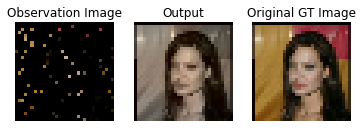

Epoch  0
Loss:  -0.3496608157544883


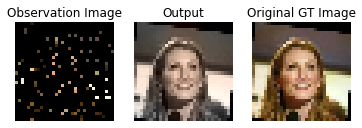

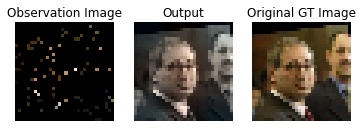

Loss:  -0.3574753732991
===
Test Epoch  0
Loss:  -0.34471142292022705


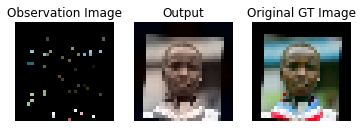

Loss:  -0.3897203505039215


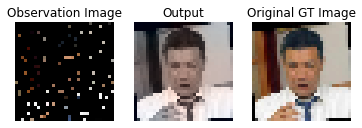

===
Epoch  1
Loss:  -0.3623065948486328


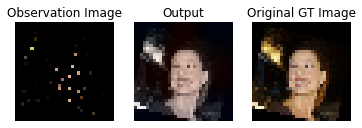

Epoch  1
Loss:  -0.36509033296238724


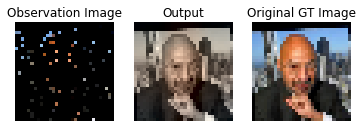

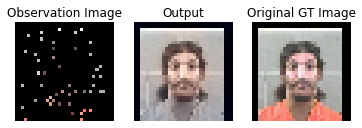

Loss:  -0.36821837340974056
===
Test Epoch  1
Loss:  -0.3751116693019867


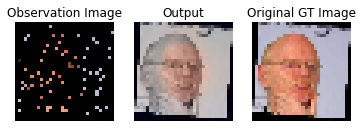

Loss:  -0.3497501015663147


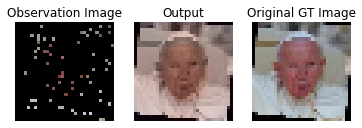

===
Epoch  2
Loss:  -0.36347612738609314


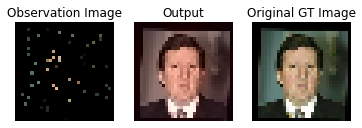

Epoch  2
Loss:  -0.37078072182574673


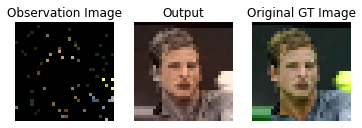

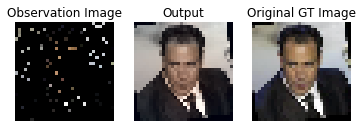

Loss:  -0.3733971085379885
===
Test Epoch  2
Loss:  -0.38449862599372864


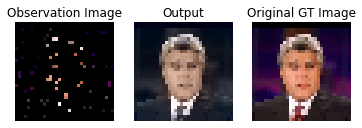

Loss:  -0.37188437581062317


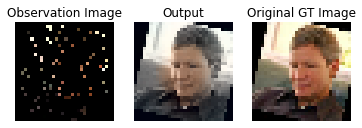

===
Epoch  3
Loss:  -0.3730418086051941


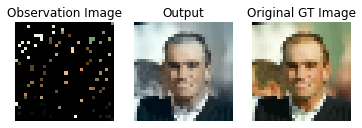

Epoch  3
Loss:  -0.3844135252397452


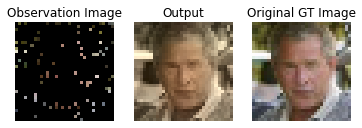

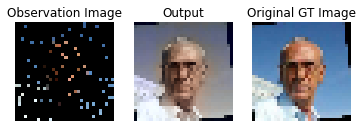

Loss:  -0.387602970472181
===
Test Epoch  3
Loss:  -0.4003118574619293


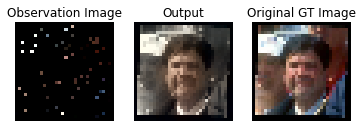

Loss:  -0.3814426064491272


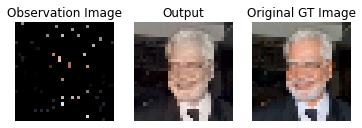

===
Epoch  4
Loss:  -0.385427862405777


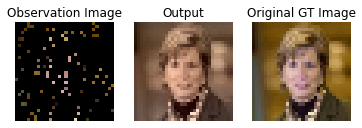

Epoch  4
Loss:  -0.3951694234390164


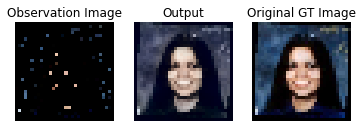

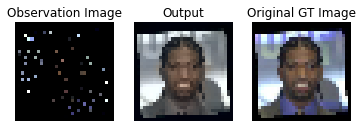

Loss:  -0.3971517318518374
===
Test Epoch  4
Loss:  -0.4126262664794922


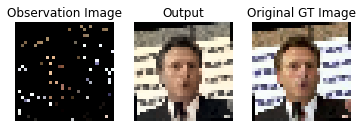

Loss:  -0.40620124340057373


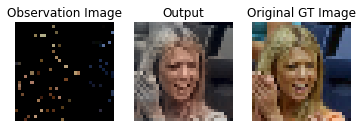

===
Epoch  5
Loss:  -0.3877401649951935


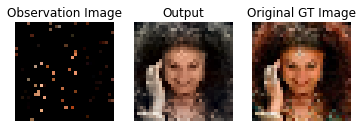

Epoch  5
Loss:  -0.40250474614883536


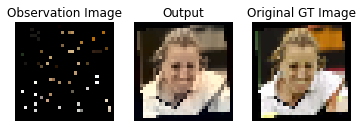

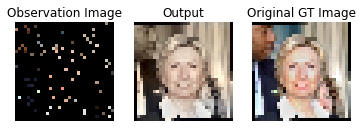

Loss:  -0.40453050351891845
===
Test Epoch  5
Loss:  -0.40675193071365356


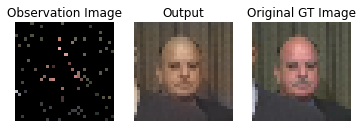

Loss:  -0.39846253395080566


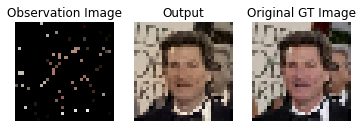

===
Epoch  6
Loss:  -0.41264235973358154


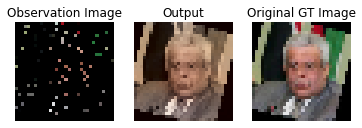

Epoch  6
Loss:  -0.4083665572292176


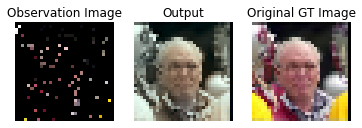

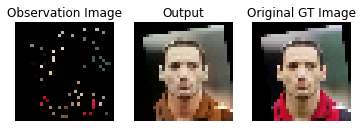

Loss:  -0.41085670623167647
===
Test Epoch  6
Loss:  -0.4146844744682312


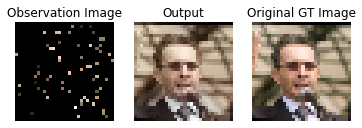

Loss:  -0.4114478826522827


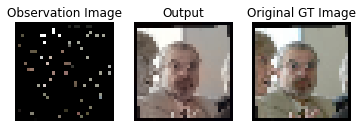

===
Epoch  7
Loss:  -0.4178502559661865


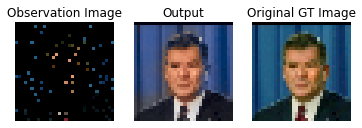

Epoch  7
Loss:  -0.41422569247620616


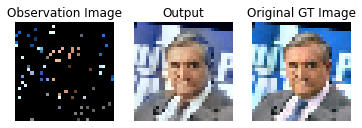

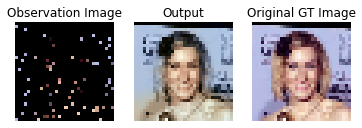

Loss:  -0.4154858597754184
===
Test Epoch  7
Loss:  -0.42769941687583923


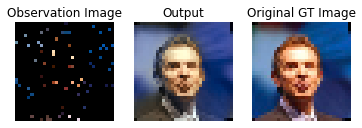

Loss:  -0.40663260221481323


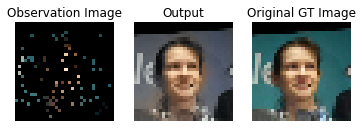

===
Epoch  8
Loss:  -0.4247485399246216


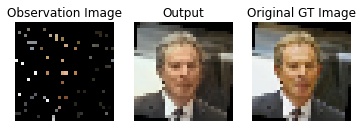

Epoch  8
Loss:  -0.41903717200554425


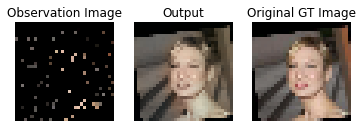

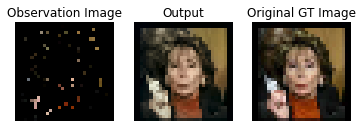

Loss:  -0.4213808040032212
===
Test Epoch  8
Loss:  -0.42583349347114563


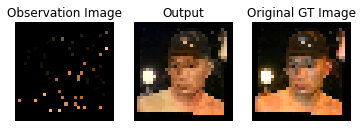

Loss:  -0.42667216062545776


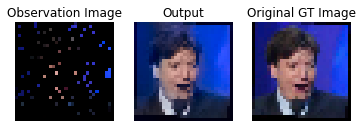

===
Epoch  9
Loss:  -0.4331762194633484


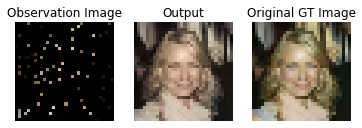

Epoch  9
Loss:  -0.4291482481790419


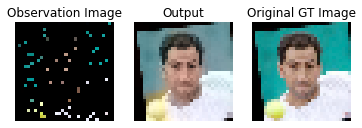

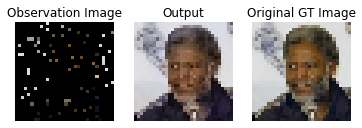

Loss:  -0.43149221512971747
===
Test Epoch  9
Loss:  -0.43204227089881897


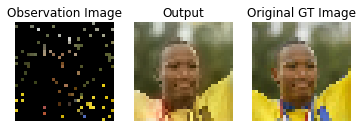

Loss:  -0.4425669312477112


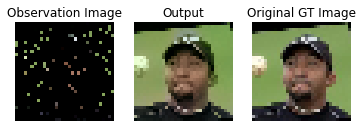

===
Epoch  10
Loss:  -0.4354921281337738


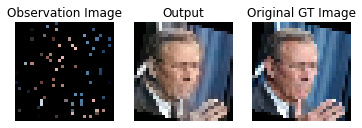

Epoch  10
Loss:  -0.4369879087701959


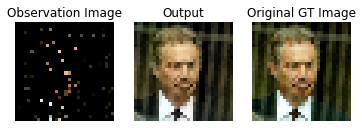

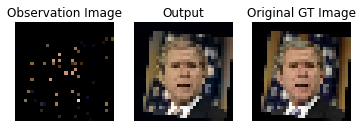

Loss:  -0.4380436552912777
===
Test Epoch  10
Loss:  -0.4330004155635834


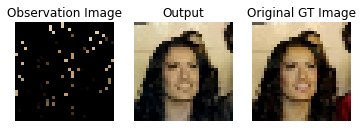

Loss:  -0.44131678342819214


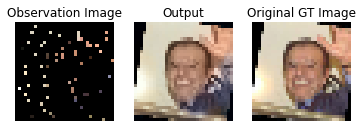

===
Epoch  11
Loss:  -0.43392831087112427


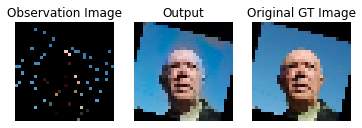

Epoch  11
Loss:  -0.44053666152764315


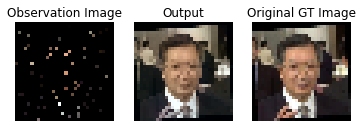

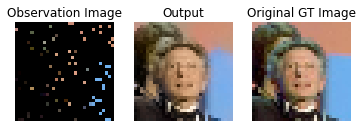

Loss:  -0.4406493729789844
===
Test Epoch  11
Loss:  -0.43774083256721497


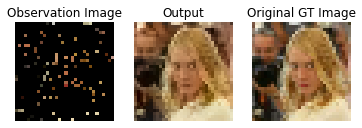

Loss:  -0.4408532977104187


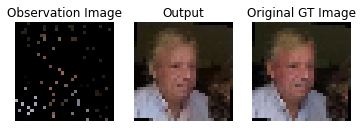

===
Epoch  12
Loss:  -0.4424583911895752


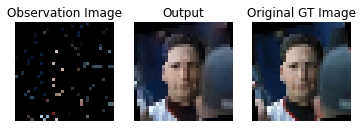

Epoch  12
Loss:  -0.4419057538260275


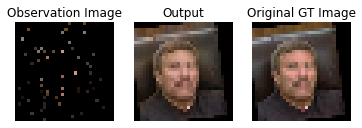

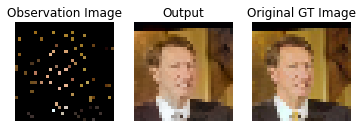

Loss:  -0.44211165482149073
===
Test Epoch  12
Loss:  -0.4378187358379364


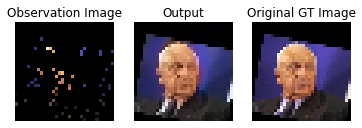

Loss:  -0.4405966103076935


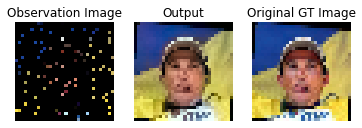

===
Epoch  13
Loss:  -0.44252437353134155


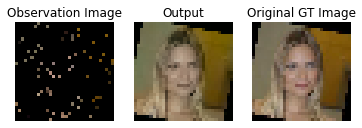

Epoch  13
Loss:  -0.4425359363876172


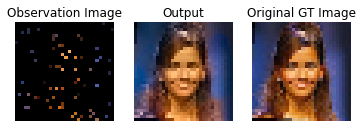

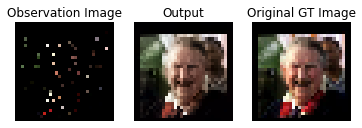

Loss:  -0.4426678718696714
===
Test Epoch  13
Loss:  -0.44494175910949707


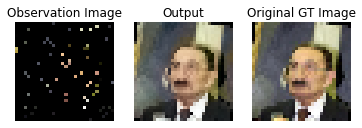

Loss:  -0.44465935230255127


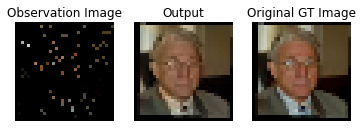

===
Epoch  14
Loss:  -0.44598501920700073


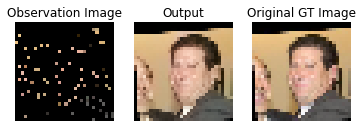

Epoch  14
Loss:  -0.4432368813759059


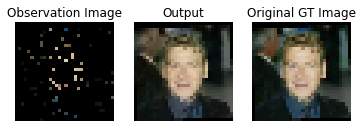

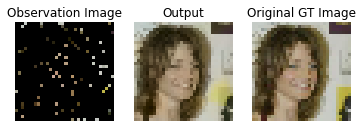

Loss:  -0.44355715413368185
===
Test Epoch  14
Loss:  -0.43920308351516724


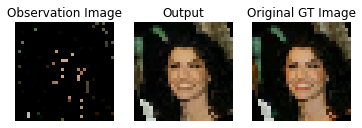

Loss:  -0.443770170211792


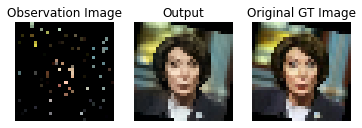

===
Epoch  15
Loss:  -0.4461050033569336


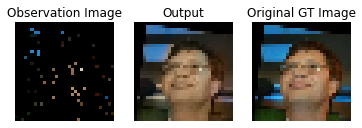

Epoch  15
Loss:  -0.4436845825382726


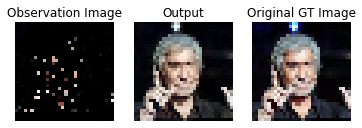

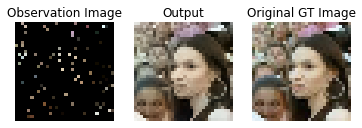

Loss:  -0.4440015552087604
===
Test Epoch  15
Loss:  -0.44844719767570496


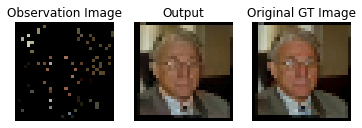

Loss:  -0.4451592266559601


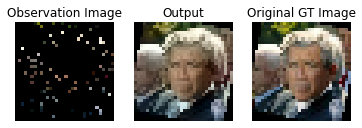

===
Epoch  16
Loss:  -0.44485950469970703


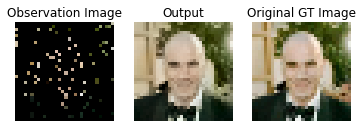

Epoch  16
Loss:  -0.4439805780180651


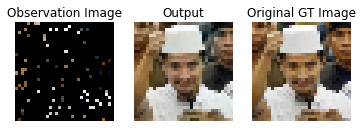

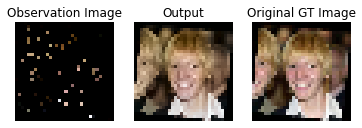

Loss:  -0.4442900225754184
===
Test Epoch  16
Loss:  -0.4454556703567505


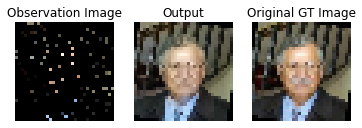

Loss:  -0.44479942321777344


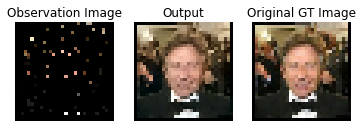

===
Epoch  17
Loss:  -0.43615061044692993


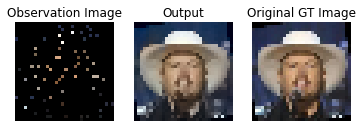

Epoch  17
Loss:  -0.4446465327075465


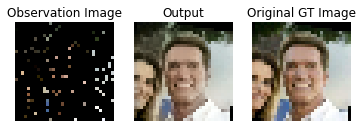

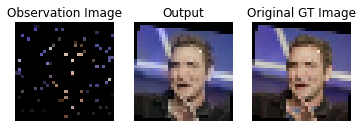

Loss:  -0.44464744526054223
===
Test Epoch  17
Loss:  -0.4461505115032196


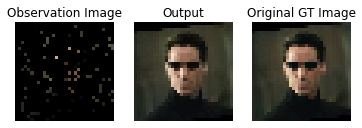

Loss:  -0.445327490568161


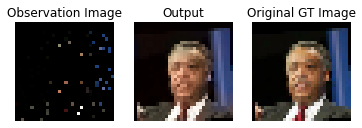

===
Epoch  18
Loss:  -0.4369804561138153


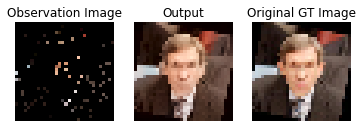

Epoch  18
Loss:  -0.4445764449105334


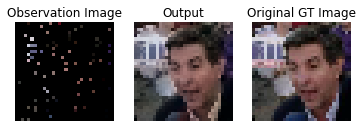

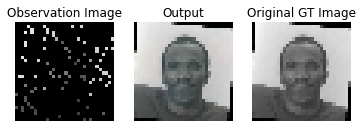

Loss:  -0.44477632485759194
===
Test Epoch  18
Loss:  -0.4435269832611084


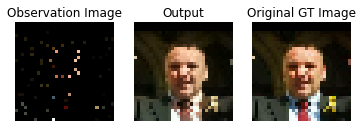

Loss:  -0.4464319348335266


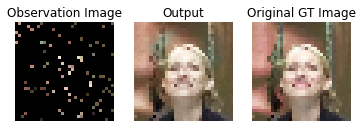

===
Epoch  19
Loss:  -0.449134886264801


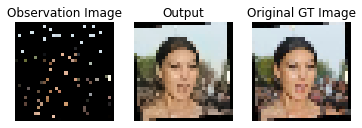

Epoch  19
Loss:  -0.4451381789511116


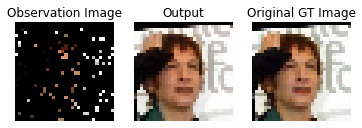

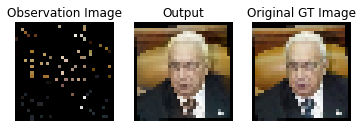

Loss:  -0.4452287055434981
===
Test Epoch  19
Loss:  -0.43846380710601807


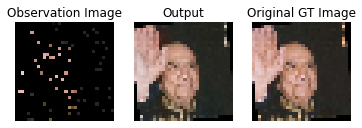

Loss:  -0.4461416006088257


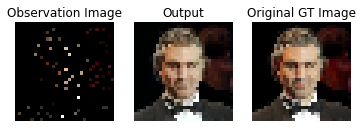

===
Epoch  20
Loss:  -0.4435003697872162


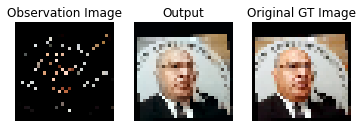

Epoch  20
Loss:  -0.4453101297516135


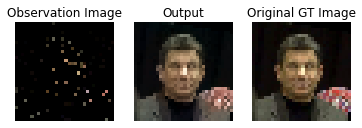

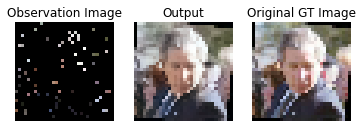

Loss:  -0.4453882838731037
===
Test Epoch  20
Loss:  -0.4507163465023041


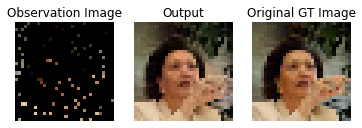

Loss:  -0.4435640573501587


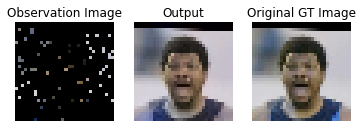

===
Epoch  21
Loss:  -0.4351995289325714


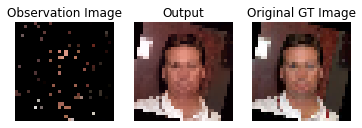

Epoch  21
Loss:  -0.44544224567081203


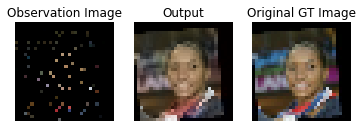

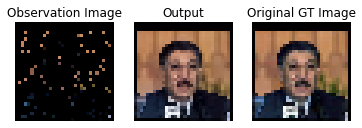

Loss:  -0.4454988198286576
===
Test Epoch  21
Loss:  -0.44371163845062256


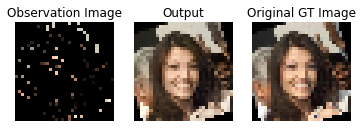

Loss:  -0.43895223736763


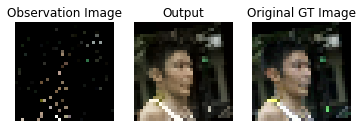

===
Epoch  22
Loss:  -0.44565922021865845


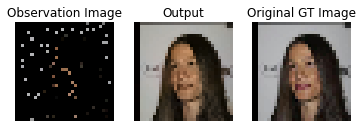

Epoch  22
Loss:  -0.44571211163084307


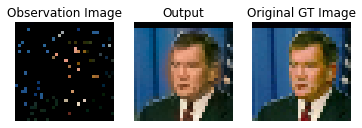

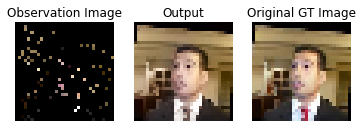

Loss:  -0.4457292355479994
===
Test Epoch  22
Loss:  -0.44139888882637024


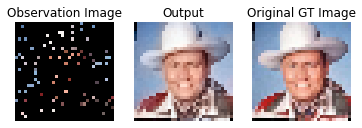

Loss:  -0.44899994134902954


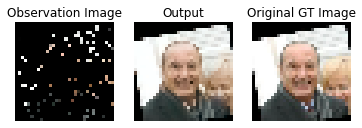

===
Epoch  23
Loss:  -0.4442138969898224


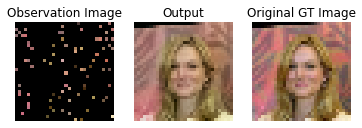

Epoch  23
Loss:  -0.4461262549333905


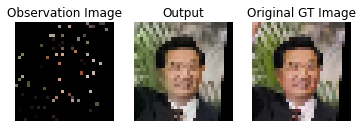

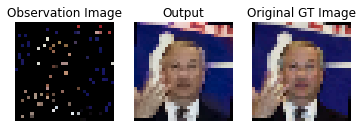

Loss:  -0.44601347683611964
===
Test Epoch  23
Loss:  -0.4501298666000366


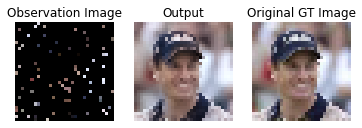

Loss:  -0.44198668003082275


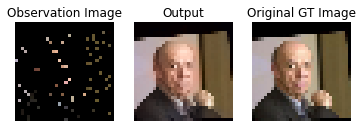

===
Epoch  24
Loss:  -0.4404694437980652


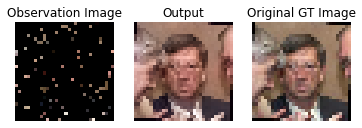

Epoch  24
Loss:  -0.44588843773846604


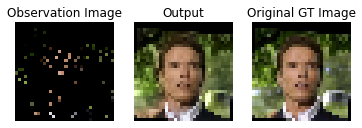

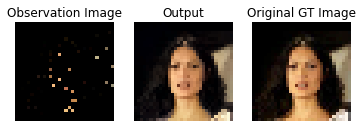

Loss:  -0.44602742252861644
===
Test Epoch  24
Loss:  -0.4489942789077759


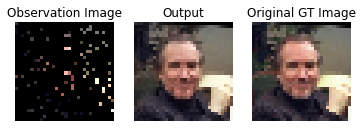

Loss:  -0.43650704622268677


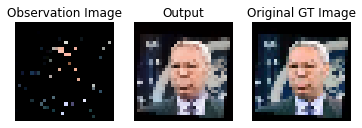

===
Epoch  25
Loss:  -0.44269272685050964


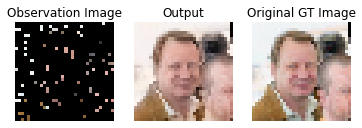

Epoch  25
Loss:  -0.44630499680836994


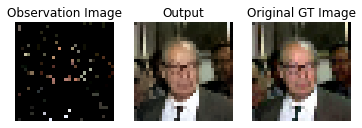

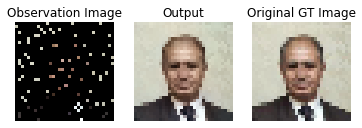

Loss:  -0.44609699495799876
===
Test Epoch  25
Loss:  -0.4453197121620178


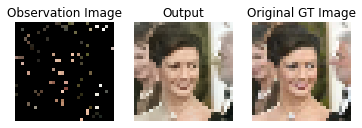

Loss:  -0.4416968822479248


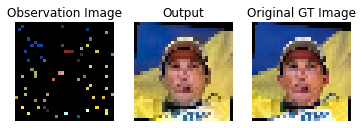

===
Epoch  26
Loss:  -0.44666391611099243


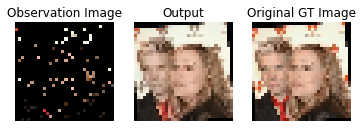

Epoch  26
Loss:  -0.4461902172411259


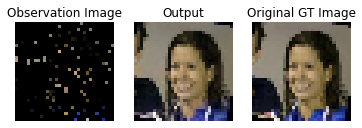

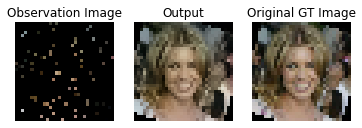

Loss:  -0.446475103185439
===
Test Epoch  26
Loss:  -0.44248974323272705


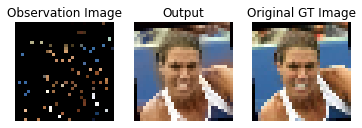

Loss:  -0.44370347261428833


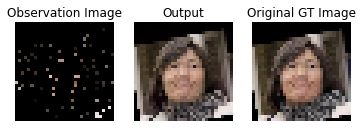

===
Epoch  27
Loss:  -0.4435291290283203


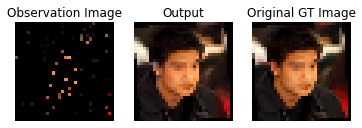

Epoch  27
Loss:  -0.4465463966576021


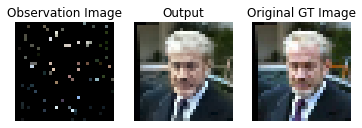

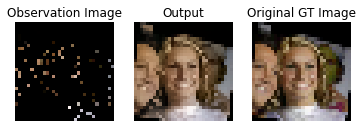

Loss:  -0.4464185847193783
===
Test Epoch  27
Loss:  -0.44869792461395264


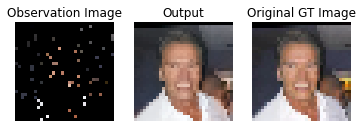

Loss:  -0.4426440894603729


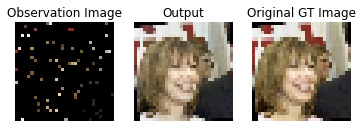

===
Epoch  28
Loss:  -0.44165176153182983


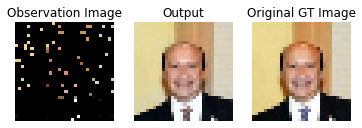

Epoch  28
Loss:  -0.4464465702944134


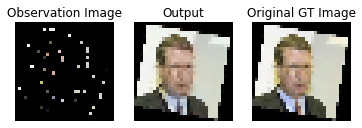

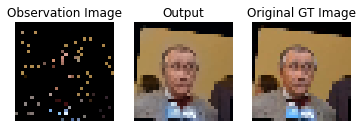

Loss:  -0.4465685308915782
===
Test Epoch  28
Loss:  -0.44810688495635986


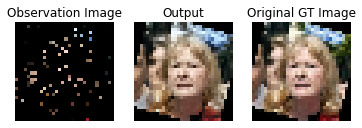

Loss:  -0.4477992653846741


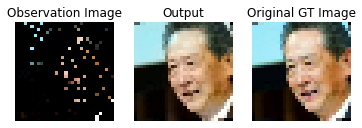

===
Epoch  29
Loss:  -0.43855899572372437


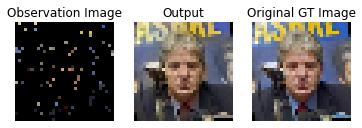

Epoch  29
Loss:  -0.4466667381388631


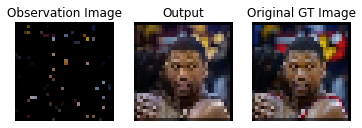

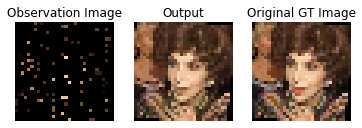

Loss:  -0.4466839918759481
===
Test Epoch  29
Loss:  -0.44646012783050537


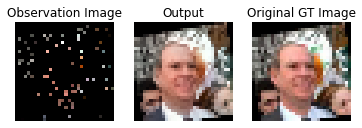

Loss:  -0.4509403705596924


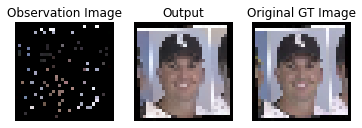

===


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 30
visualize_freq = 200

losses = []
losses_a = []
losses_b = []

for epoch in range(epochs):
    _loss, _loss_a, _loss_b = 0., 0., 0.

    model.train()
    for i, (color_c, gray_c, obs, preds, preds_gt, coords_obs, coords_pred) in enumerate(train_loader):
        optimizer.zero_grad()
        obs, preds, preds_gt = obs.to(0), preds.to(0), preds_gt.to(0)
        # print(preds_gt.shape)

        query = ((obs[:,:,:41].float(),obs[:,:,41:].float()), preds.float())
        mu, sigma, _, _, loss = model(query, 32 * 32, preds_gt.float())
        mu_a, mu_b = torch.chunk(mu, 2, dim=-1)
        sigma_a, sigma_b = torch.chunk(sigma, 2, dim=-1)

        loss.backward()
        optimizer.step()
        _loss += loss.item()
        if i % visualize_freq == 0:
            print("Epoch ", epoch)
            print("Loss: ", _loss/(i+1))
            # if not os.path.exists("image_outputs"):
            #     os.makedirs("image_outputs")
            visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b) 
                      #,out_dir = "image_outputs/" + str(epoch) + "_" + str(i) + ".jpg")
    losses.append(_loss/(i+1))
    visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b)
                      #,out_dir = "image_outputs/" + str(epoch) + "_" + str(i) + ".jpg")
    print("Loss: ", _loss/(i+1))
    print("===")

    # Visualize test data
    print("Test Epoch ", epoch)
    model.eval()
    for i, (color_c, gray_c, obs, preds, preds_gt, coords_obs, coords_pred) in enumerate(test_loader):
        optimizer.zero_grad()
        obs, preds, preds_gt = obs.to(0), preds.to(0), preds_gt.to(0)
        # print(preds_gt.shape)

        query = ((obs[:,:,:41].float(),obs[:,:,41:].float()), preds.float())
        mu, sigma, _, _, loss = model(query, 32 * 32, preds_gt.float())
        mu_a, mu_b = torch.chunk(mu, 2, dim=-1)
        sigma_a, sigma_b = torch.chunk(sigma, 2, dim=-1)

        optimizer.step()    
        print("Loss: ", loss.item())
        visualize(gray_c, color_c, coords_obs, coords_pred, mu_a, mu_b)
        # only test a few
        if i == 1:
            break
    print("===")